In [2]:
%load_ext rpy2.ipython

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile

In [12]:
tif_path = 'data/VIIRS/SVDNB_npp_20161201-20161231_75N180W_vcmcfg_v10_c201701271136.cf_cvg.tif'
tif_out_path = 'data/VIIRS/generated/'

In [5]:
with TiffFile(tif_path) as tif:
    image = 1 / tif.asarray()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [6]:
equator_circumfence = 40030 # km, obviously

In [23]:
image.shape

(16801, 43201)

## Mosaics

In [33]:
tif_paths = [
    'data/VIIRS/F101992.v4/F101992.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif'
]
n = 16801
m = 43201

images = np.zeros((len(tif_paths),n,m))
                  
for i, p in enumerate(tif_paths):
    with TiffFile(p) as tif:
        images[i] = tif.asarray()

Lets find Barcelona and compare (1992 to 1993). Not a lot happened.

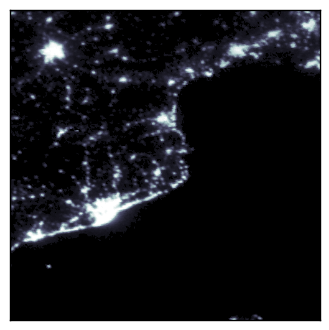

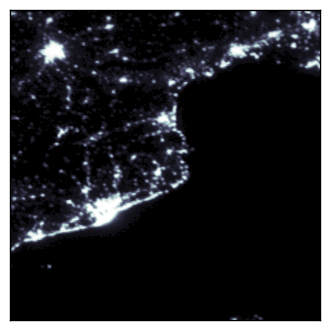

In [46]:
for i, image in enumerate(images):
#     plt.imshow(image[3500:4500,21500:22500], cmap='bone')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    plt.imshow(image[3700:4200,21700:22200], cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#     plt.imshow(image[3970:4070,21800:21900], cmap='bone')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [5]:
image[(image == np.inf)] = 1
image = image - image.min()

$$
\begin{aligned}
d &= 2 \text{  since it's an image} \\
k_d&: \text{  integer that can divide } k_d \in {n,m}\\
\delta_d&: \text{  integer that can divide } k_d \implies d\\
L_{n \times m}&: \text{ pixel luminosity } l \in (0,1)\\
S &: s_i \in \mathbb{L}_{n \times m}
\end{aligned}
$$

In [27]:
dimension = 2
sub_image_shape = (300,300) # k
step_size = (150,150) # delta

passes = [int(image.shape[i]/step_size[i]-sub_image_shape[i]/step_size[i]+1) for i in range(dimension)]

simages = np.zeros((*passes,*sub_image_shape))
simages_coordinates = np.zeros((*passes,2,2))

step = np.zeros(dimension)

for i in range(passes[0]):
    step_i = i*step_size[0]
    for j in range(passes[1]):
        step_j = j*step_size[1]
        sub_image = image[step_i:(step_i+sub_image_shape[0]),
                          step_j:(step_j+sub_image_shape[1])]
        sub_image_coordinates = [
            [step_i,step_i+sub_image_shape[0]],
            [step_j,step_j+sub_image_shape[1]]
        ]
        if sub_image.shape != sub_image_shape:
            raise(Exception(sub_image))
            
        simages[i,j] = sub_image
        simages_coordinates[i,j] = sub_image_coordinates

In [7]:
simages_mean_lum = simages.mean(axis=(2,3))
# pd.DataFrame(simages_mean_lum).to_csv('simages_mean_lum.csv')

In [8]:
simages.shape

(111, 287, 300, 300)

Only very few of the subimages contain a lot of lighting. This is good since we only want to extract areas with lots of luminosity information.

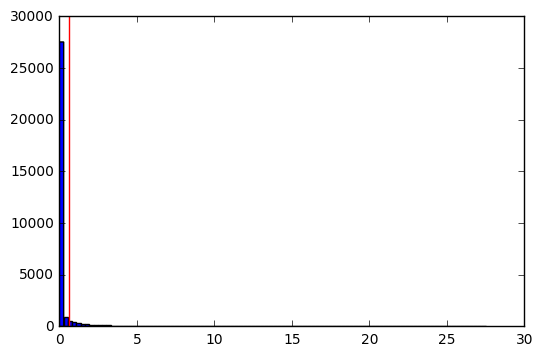

In [9]:
axs[j]hist(simages_mean_lum.reshape(-1,1), bins=100)
axs[j]axvline(x=np.percentile(simages_mean_lum,90),color="red")
axs[j]show()

In [15]:
selected_simages = simages[simages_mean_lum > np.percentile(simages_mean_lum,90)]

In [16]:
selected_simages.shape

(3186, 300, 300)

Lets find the brightest spots on earth 
* This really needs coordinates

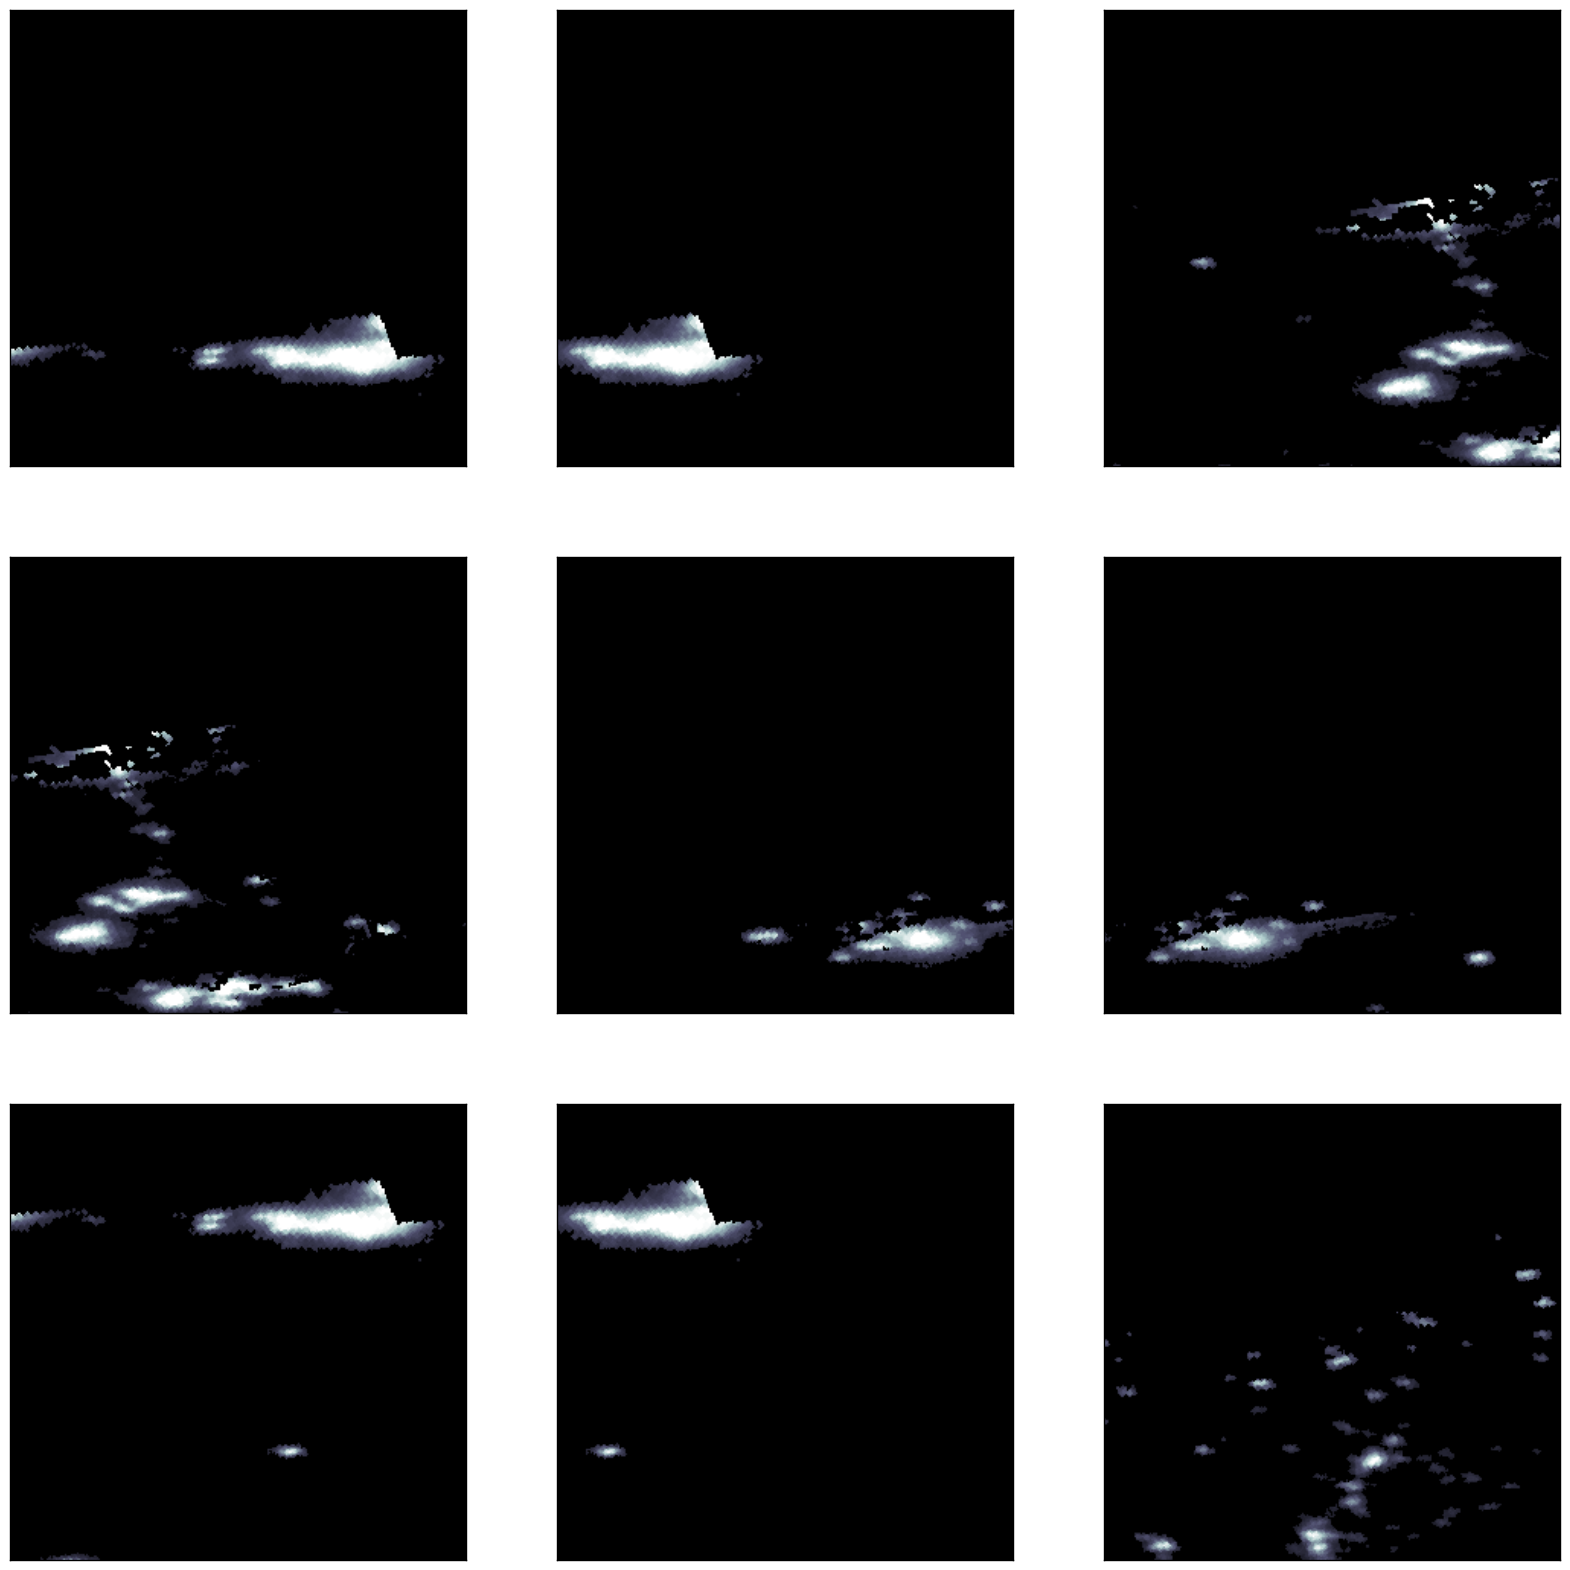

In [24]:
fig, ax = axs[j]subplots(3,3,figsize=(20,20))
for i, axi, in enumerate(ax.flat):
    axi.imshow(selected_simages[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

## Calculate Luminosity Change over time period
$$
\mathbb{L}_{i+1} - \mathbb{L}_{i} = \mathbb{L}_{\delta} \text{ luminosity delta}
$$

fig, ax = axs[j]subplots(3,3,figsize=(20,20))
for i, axi, in enumerate(ax.flat):
    axi.imshow(selected_simages[i] - selected_simages[i+1] != 0, cmap = 'bone')
    axi.set(xticks=[], yticks=[])